In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
class EinsteinRelation:
    def __init__(self, 
                 xdatcar="",
                 outcar="",
                 segments=1, 
                 skip=0,
                 skip2=0, 
                 verbose=True,
                 getD=True):
        
        if os.path.isfile(xdatcar):
            self.xdatcar = xdatcar
        else:
            print(f"{xdatcar} is not found.")
            sys.exit(0)

        if os.path.isfile(outcar):
            self.outcar = outcar
        else:
            print(f"{outcar} is not found.")
            sys.exit()
            
        self.verbose = verbose
        
        # read outcar
        self.potim = None
        self.nblock = None
        self.read_outcar()

        # read XDATCAR
        self.TypeName = None    # List of atom species
        self.Ntype = None       # Number of atom species
        self.Nions = None       # Total number of atom
        self.Nelem = None       # Number of each atoms
        self.Niter = None       # Number of steps
        self.position = None    # Direct coordination of atoms
        self.cell = None        # Lattice of cell
        self.read_xdatcar()

        self.ChemSymb = None
        self.symbol_list()

        # Parameters for skip
        self.segments = segments    # Dividing whole MD steps into segments
        self.skip = skip            # Skipping initial steps for whole MD steps
        self.skip2 = skip2          # Skipping initial steps for each segments

        Time = self.Niter * self.potim * self.nblock
        if self.verbose:
            print("\t--- MD information ---")
            print(f"\ttotal time = {Time/1000} ps")

        # Mean square distance
        self.msd = None
        self.getmsd()
        
        # Diffusivity.
        # For ensemble calculation, please set getD = False to save time
        self.diffcoeff = None
        self.intercept = None
        self.ddiffcoeff = None  # Deviation of D

        if getD is True:
            self.getdiff()

        if self.verbose:
            self.plot_msd()
    
    def read_outcar(self):
        if self.verbose:
            print(f"reading {self.outcar}...")
        with open(self.outcar, 'r') as file:
            lines_outcar = [line.strip() for line in file]

        self.potim, self.nblock, lm = 0, 0, 0
        for num, line in enumerate(lines_outcar):
            if 'POTIM' in line:
                self.potim = float(line.split()[2])
            if 'NBLOCK' in line:
                self.nblock = int(line.split()[2].replace(';',''))
            if 'Mass of Ions in am' in line:
                lm = num + 1
            if self.potim and self.nblock and lm:
                break

        if self.verbose:
            print(f"\tpotim = {self.potim}")
            print(f"\tnblock = {self.nblock}\n")
    
    def read_xdatcar(self):
        if self.verbose:
            print(f"reading {self.xdatcar}...")
        with open(self.xdatcar,'r') as file:
            inp = [line.strip() for line in file]
        scale = float(inp[1])
        self.cell = np.array([line.split() for line in inp[2:5]], dtype=float)
        self.cell *= scale

        ta = inp[5].split()
        tb = inp[6].split()
        if ta[0].isalpha():
            self.TypeName = ta
            self.Ntype = len(ta)
            self.Nelem = np.array(tb, dtype=int)
            self.Nions = self.Nelem.sum()
        if self.verbose:
            print(f"\tatom type = {self.TypeName}")
            print(f"\tnumber of type = {self.Ntype}")
            print(f"\tnumber of atom = {self.Nelem}")
            print(f"\ttotal number of atom = {self.Nions}")

        pos = np.array(
            [line.split() for line in inp[7:] if not line.split()[0].isalpha()],
            dtype=float)
        self.position = pos.flatten().reshape((-1,self.Nions,3))
        self.Niter = self.position.shape[0]
        if self.verbose:
            print(f"\tshape of position = {self.position.shape} #(nsw, number of atom, xyz)\n")

    def symbol_list(self):
        self.ChemSymb = []
        for i in range(self.Ntype):
            self.ChemSymb += [np.tile(self.TypeName[i], self.Nelem[i])]
        self.ChemSymb = np.concatenate(self.ChemSymb)
    
    def getmsd(self):
        # length of segment
        seglength = int(np.floor((self.Niter-self.skip)/self.segments))
        if self.verbose:
            print(f"\tnumber of segments = {self.segments}")
            print(f"\tsegment length = {seglength}")

        # msd for (each segment), (each type of element), (each step), and, (x, y, z)
        self.msd=np.zeros(shape=(self.segments, self.Ntype, seglength, 3))

        for i in range(self.segments):
            # displacement [step,atom_idx,xyz]
            displacement = np.zeros_like(
                self.position[self.skip+seglength*i:self.skip+seglength*(i+1),:])
            displacement[0,:,:] = 0
            displacement[1:,:,:] = np.diff(
                self.position[self.skip+seglength*i:self.skip+seglength*(i+1),:], axis=0)

            # wrap back into box
            displacement[displacement > 0.5] -= 1.0
            displacement[displacement < -0.5] += 1.0

            # vector of accumulated displacement
            displacement = np.cumsum(displacement, axis=0)
        
            displacementC = np.zeros_like(displacement)
            displacementC = np.dot(displacement[:,:,:], self.cell)  # Direct to Cartesian

            # squared displacement in x, y, z
            displacementC[:,:,:] =  displacementC[:,:,:]**2

            for j in range(self.Ntype):
                if j==0:
                    labelst=0
                else:
                    labelst = np.sum(self.Nelem[:j])
                labeled = np.sum(self.Nelem[:j+1])
                self.msd[i,j,:,:] = np.average(displacementC[:,labelst:labeled,:], axis=1) 

        if self.verbose:
            print(f"\tshape of msd = {self.msd.shape} #(segment, number of type, nsw - skip, xyz)\n")
                
    def getdiff(self):
        self.diffcoeff = np.zeros(shape=(self.segments, self.Ntype, 3))
        self.intercept = np.zeros(shape=(self.segments, self.Ntype, 3))
        self.ddiffcoeff = np.zeros(shape=(self.Ntype, 3))

        for i in range(self.segments):           # loop over segments
            for j in range(self.Ntype):          # loop over type of elements
                for k in range(3):               # loop over x.y,z
                    # time unit in fs, distance unit in A, unit in m^2/s
                    if np.floor((self.Niter-self.skip)/self.segments) < 2*self.skip2:   
                        # too large skip2... skip2 is automatically set to 0
                        self.diffcoeff[i,j,k], self.intercept[i,j,k]=np.polyfit(
                                self.potim*self.nblock*
                                np.arange(np.floor((self.Niter-self.skip)/self.segments)),
                                1E-5*self.msd[i,j,:,k], 
                                deg=1)
                    else:
                        self.diffcoeff[i,j,k], self.intercept[i,j,k] = np.polyfit(
                                self.potim*self.nblock*
                                np.arange(np.floor((self.Niter-self.skip)/self.segments)-self.skip2), 
                                1E-5*self.msd[i,j,self.skip2:,k],
                                deg=1)
                        
        # standard deviation of D over segments for x,y,z directions
        self.diffcoeff /= 2      # x, y, z 각각에 대해 계산되었음 -> 1차원임 -> 2로 나누어짐
        self.ddiffcoeff = np.std(self.diffcoeff, axis=0) / 2
    
    def get_msd_specific_atom(self, symbol):
        if symbol in self.TypeName:
            idx = np.where(np.array(self.TypeName) == symbol)[0][0]
            return self.msd[:,idx,:,:]  # shape: [1, steps, 3:xyz]
        else:
            print("No matched atom!")
            return None
        
    def plot_msd(self):
        time = np.arange(self.skip, self.Niter) * self.potim / 1000
        for type in self.TypeName:
            msd = np.sum(self.get_msd_specific_atom(symbol=type).squeeze(), axis=1)
            plt.plot(time, msd, label=type)
        plt.xlabel('t (ps)', fontsize=13)
        plt.ylabel(r'MSD ($Å^2$)', fontsize=13)
        # plt.ylabel(r'$<\Delta r^{2}> (Å^2)$', fontsize=13)
        plt.legend(fontsize=13)
        plt.show()

reading xdatcar/xdatcar.2000K/OUTCAR...
	potim = 2.0
	nblock = 1

reading xdatcar/xdatcar.2000K/XDATCAR_01...
	atom type = ['Hf', 'O']
	number of type = 2
	number of atom = [34 34]
	total number of atom = 68
	shape of position = (15000, 68, 3) #(nsw, number of atom, xyz)

	--- MD information ---
	total time = 30.0 ps
	number of segments = 1
	segment length = 14500
	shape of msd = (1, 2, 14500, 3) #(segment, number of type, nsw - skip, xyz)



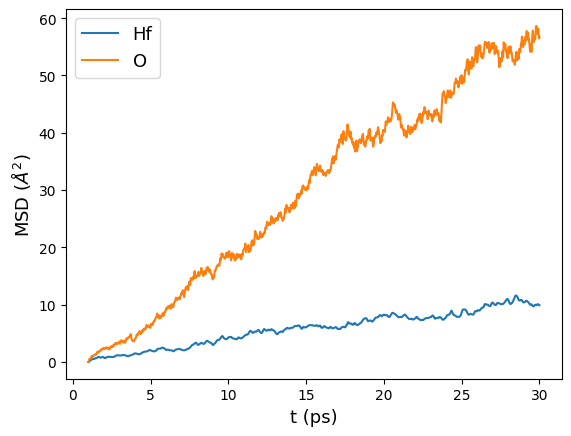

shape of D : (1, 2, 3) #(segment, number of type, xyz)

D of Hf : 5.821892348705656e-10 m2/s
D of O  : 3.447616976791206e-09 m2/s


In [3]:
# Test
xdatcar = "xdatcar/xdatcar.2000K/XDATCAR_01"
outcar = "xdatcar/xdatcar.2000K/OUTCAR"

example = EinsteinRelation(xdatcar=xdatcar,
                           outcar=outcar, 
                           segments=1, 
                           skip=500, 
                           verbose=True,
                           getD=True)

print(f"shape of D : {example.diffcoeff.shape} #(segment, number of type, xyz)\n") 
print(f"D of Hf : {np.average(example.diffcoeff[0][0])} m2/s")
print(f"D of O  : {np.average(example.diffcoeff[0][1])} m2/s")

In [4]:
class EnsembleEinstein:
    def __init__(self, symbol, prefix, labels, segments, skip, start=None, end=None):
        ## XDATCAR format : XDATCAR_{label}
        ## OUTCAR format : OUTCAR

        ## Arguments
        self.symbol = symbol        # ex: 'O'
        self.prefix = prefix        # ex: 'xdatcar/xdatcar.2000K/'
        if self.prefix[-1] != '/':
            self.prefix += '/'
        self.labels = labels        # ex: np.arange(1000, 20000+1, 1000)
        self.segments = segments    # See MD2D for description about segments
        self.skip = skip
        ## args : 'start' and 'end' : Fitting range

        # Properties of NVT ensembles
        self.msd_xyz = None         # shape: (steps, 3;xyz)
        self.msd = None             # shape: (steps, )
        self.msd_x = None
        self.msd_y = None
        self.msd_z = None

        self.potim = None
        self.nblock = None

        self.diffcoeff = None       # m2/s
        self.intercept = None
        
        self.diffcoeff_x = None     
        self.intercept_x = None
        
        self.diffcoeff_y = None     
        self.intercept_y = None
        
        self.diffcoeff_z = None     
        self.intercept_z = None

        # For linear fitting
        self.start = start          # Step number in MD simulation
        self.end = end
        self.timestep = None        # [ps]

        self.getEnsembleMSD()

        if start is not None and end is not None:
            _, __ = self.getEnsembleD()
            _, __ = self.getEnsembleD_x()
            _, __ = self.getEnsembleD_y()
            _, __ = self.getEnsembleD_z()

    def getEnsembleMSD(self):
        desc = self.prefix.split('/')[-1] if len(self.prefix.split('/')[-1]) > 0 \
            else  self.prefix.split('/')[-2]
        
        for label in tqdm(self.labels, desc=desc):
            xdatcar = self.prefix + "XDATCAR_" + str(label)
            outcar = self.prefix + "OUTCAR"
            ensemble = EinsteinRelation(xdatcar=xdatcar,
                                        outcar=outcar,
                                        segments=self.segments,
                                        skip=self.skip,
                                        verbose=False,
                                        getD=False)
            if self.msd_xyz is None:
                self.msd_xyz = ensemble.get_msd_specific_atom(symbol=self.symbol)
                self.potim = ensemble.potim
                self.nblock = ensemble.nblock
            else:
                self.msd_xyz = np.append(self.msd_xyz, 
                                         ensemble.get_msd_specific_atom(symbol=self.symbol), axis=0)
        
        self.msd_xyz = np.mean(self.msd_xyz, axis=0)
        self.msd = np.sum(self.msd_xyz, axis=1)
        self.timestep = np.arange(self.msd[:].shape[0]) * self.potim * self.nblock / 1000

    def getEnsembleD(self, *args):
        if len(args) == 2:
            self.start, self.end = args[0], args[1]
        if self.start is None or self.end is None:
            sys.exit("start and end are needed to determine fitting range.")

        self.diffcoeff, self.intercept = np.polyfit(6*self.potim*self.nblock*np.arange(self.end-self.start),
                                                    1E-5*self.msd[self.start:self.end], 
                                                    deg=1)
        return self.diffcoeff, self.intercept
    
    def plotEnsembleMSD(self):
        temp = self.prefix.split('/')[-2].split('.')[-1]
        plt.plot(self.timestep, self.msd[:], label=f"{temp}")

        if self.diffcoeff is not None:
            # visualize fitting line
            plt.plot(np.arange(self.start, self.end)*self.potim*self.nblock/1000, 
                     self.diffcoeff*(6*self.potim*self.nblock*1.0E5)*
                     np.arange(self.end-self.start)+self.intercept*1.0E5, 
                     'k:')
            # visualize fitting range
            plt.axvline(self.start*self.potim*self.nblock/1000, 0, 1, color='black', linewidth=0.5)
            plt.axvline(self.end*self.potim*self.nblock/1000, 0, 1, color='black', linewidth=0.5)

        plt.legend(loc='upper left')
        plt.xlabel('t (ps)', fontsize=13)
        plt.ylabel(r'MSD ($Å^2$)', fontsize=13)

    def getEnsembleD_x(self, *args):
        if len(args) == 2:
            self.start, self.end = args[0], args[1]
        if self.start is None or self.end is None:
            sys.exit("start and end are needed to determine fitting range.")

        self.msd_x = self.msd_xyz[:,0]
        self.diffcoeff_x, self.intercept_x = np.polyfit(2*self.potim*self.nblock*
                                                        np.arange(self.end-self.start),
                                                        1E-5*self.msd_x[self.start:self.end],
                                                        deg=1)
        return self.diffcoeff_x, self.intercept_x
    
    def plotEnsembleMSD_x(self):
        temp = self.prefix.split('/')[-2].split('.')[-1]
        plt.plot(self.timestep, self.msd_x[:], label=f"{temp}")

        if self.diffcoeff_x is not None:
            # visualize fitting line
            plt.plot(np.arange(self.start, self.end) * self.potim * self.nblock / 1000, 
                     self.diffcoeff_x*(2*self.potim*self.nblock*1.0E5)*
                     np.arange(self.end-self.start)+self.intercept_x*1.0E5, 
                     'k:')
            # visualize fitting range
            plt.axvline(self.start* self.potim * self.nblock / 1000, 0, 1, color='black', linewidth=0.5)
            plt.axvline(self.end* self.potim * self.nblock / 1000, 0, 1, color='black', linewidth=0.5)

        plt.title("x component", fontsize=14)
        plt.legend(loc='upper left')
        plt.xlabel('t (ps)', fontsize=13)
        plt.ylabel(r'MSD ($Å^2$)', fontsize=13)

    def getEnsembleD_y(self, *args):
        if len(args) == 2:
            self.start, self.end = args[0], args[1]
        if self.start is None or self.end is None:
            sys.exit("start and end are needed to determine fitting range.")

        self.msd_y = self.msd_xyz[:,1]
        self.diffcoeff_y, self.intercept_y = np.polyfit(2*self.potim*self.nblock*
                                                        np.arange(self.end - self.start), 
                                                        1E-5*self.msd_y[self.start:self.end],
                                                        deg=1)
        return self.diffcoeff_y, self.intercept_y
    
    def plotEnsembleMSD_y(self):
        temp = self.prefix.split('/')[-2].split('.')[-1]
        plt.plot(self.timestep, self.msd_y[:], label=f"{temp}")

        if self.diffcoeff_y is not None:
            # visualize fitting line
            plt.plot(np.arange(self.start, self.end) * self.potim * self.nblock / 1000, 
                     self.diffcoeff_y*(2*self.potim*self.nblock*1.0E5)*
                     np.arange(self.end-self.start)+self.intercept_y*1.0E5, 
                     'k:')
            # visualize fitting range
            plt.axvline(self.start* self.potim * self.nblock / 1000, 0, 1, color='black', linewidth=0.5)
            plt.axvline(self.end* self.potim * self.nblock / 1000, 0, 1, color='black', linewidth=0.5)

        plt.title("y component", fontsize=14)
        plt.legend(loc='upper left')
        plt.xlabel('t (ps)', fontsize=13)
        plt.ylabel(r'MSD ($Å^2$)', fontsize=13)

    def getEnsembleD_z(self, *args):
        if len(args) == 2:
            self.start, self.end = args[0], args[1]
        if self.start is None or self.end is None:
            sys.exit("start and end are needed to determine fitting range.")

        self.msd_z = self.msd_xyz[:,2]
        self.diffcoeff_z, self.intercept_z = np.polyfit(2 * self.potim * self.nblock * 
                                                        np.arange(self.end - self.start), 
                                                        1E-5 * self.msd_z[self.start:self.end],
                                                        deg=1)
        return self.diffcoeff_z, self.intercept_z
    
    def plotEnsembleMSD_z(self):
        temp = self.prefix.split('/')[-2].split('.')[-1]
        plt.plot(self.timestep, self.msd_z[:], label=f"{temp}")

        if self.diffcoeff_z is not None:
            # visualize fitting line
            plt.plot(np.arange(self.start, self.end) * self.potim * self.nblock / 1000, 
                     self.diffcoeff_z*(2*self.potim*self.nblock*1.0E5)*
                     np.arange(self.end-self.start)+self.intercept_z*1.0E5, 
                     'k:')
            # visualize fitting range
            plt.axvline(self.start* self.potim * self.nblock / 1000, 0, 1, color='black', linewidth=0.5)
            plt.axvline(self.end* self.potim * self.nblock / 1000, 0, 1, color='black', linewidth=0.5)

        plt.title("z component", fontsize=14)
        plt.legend(loc='upper left')
        plt.xlabel('t (ps)', fontsize=13)
        plt.ylabel(r'MSD ($Å^2$)', fontsize=13)
    
    def saveMSD(self):
        if not os.path.isdir('msd'):
            os.mkdir('msd')
        prefix = './msd/'
        timestep = self.timestep.reshape(self.timestep.shape[0], 1)
        msd = self.msd.reshape(self.msd.shape[0], 1)
        data_save = np.concatenate((timestep, msd), axis=1)

        temp = self.prefix.split('/')[-2].split('.')[-1]
        filename = prefix+'msd_'+temp+'.txt'
        np.savetxt(filename, data_save)

In [11]:
class getDiffusivity:
    def __init__(self, 
                 symbol,
                 label,
                 temp,
                 segment,
                 skip,
                 start,
                 end,
                 xdatcar='./xdatcar',
                 xyz=False):
        """
        Arg 1: (str) symbol; target atom (ex. 'O')
        Arg 2: (list) label; label of XDATCAR files
        Arg 3: (list) temp; range of temperature
        Arg 4: (int) segment; number of segment
        Arg 5: (int) skip; initial steps to be skipped
        Arg 6: (int) start: start step for fitting
        Arg 7: (int) end; end step for fitting
        Arg 8: (str) xdatcar; location of xdatcar folder
        Arg 9: (bool) if True, x, y, z component of D is calculated
        """
        self.symbol = symbol
        self.label = label
        self.temp = np.array(temp)
        self.segment = segment
        self.skip = skip
        self.start = start
        self.end = end
        self.prefix = xdatcar

        self.ensembles = []
        self.getEnsembles()

        self.diffcoeffs = []
        self.getD()
        self.diffcoeffs = np.array(self.diffcoeffs)

        # get Ea and D0
        self.kb = 8.617332478E-5 # eV/K
        slop, intercept = np.polyfit(1/self.temp, np.log(self.diffcoeffs), deg=1)

        self.Ea = -slop * self.kb
        self.D0 = np.exp(intercept)

        self.plotMSD()
        self.plotArrhenius(self.diffcoeffs)
        self.saveD()

        print(f"Ea = {self.Ea} eV")
        print(f"D0 = {self.D0} m2/s")

        if xyz:
            self.diffcoeffs_x = []
            self.diffcoeffs_y = []
            self.diffcoeffs_z = []
            self.getDx()
            self.getDy()
            self.getDz()
            self.plot_xyz()
            self.saveDxyz()

    def getEnsembles(self):
        for t in tqdm(self.temp):
            ensemble = EnsembleEinstein(symbol=self.symbol,
                                        prefix=os.path.join(self.prefix,f"xdatcar.{t}K"),
                                        labels=self.label,
                                        segments=self.segment,
                                        skip=self.skip,
                                        start=self.start,
                                        end=self.end)
            self.ensembles += [ensemble]
            ensemble.saveMSD()

    def getD(self):
        self.diffcoeffs = [ensemble.diffcoeff for ensemble in self.ensembles]

    def getDx(self):
        self.diffcoeffs_x = [ensemble.diffcoeff_x for ensemble in self.ensembles]

    def getDy(self):
        self.diffcoeffs_y = [ensemble.diffcoeff_y for ensemble in self.ensembles]

    def getDz(self):
        self.diffcoeffs_z = [ensemble.diffcoeff_z for ensemble in self.ensembles]

    def plotMSD(self):
        for ensemble in self.ensembles:
            ensemble.plotEnsembleMSD()
            plt.legend(loc='upper left')
            plt.xlabel('t (ps)', fontsize=13)
            plt.ylabel(r'MSD ($Å^2$)', fontsize=13)
        plt.savefig('msd.png', dpi=300, transparent=False)
        plt.show()


    def plotArrhenius(self, diffcoeffs, disp=True):
        kb = 8.617332478E-5 # eV/K
        slop, intercept = np.polyfit(1/self.temp, np.log(diffcoeffs), deg=1)
        tick = [r'$\frac{{1}}{{{}}}$'.format(t) for t in self.temp]
        Ea = -slop * kb
        D0 = np.exp(intercept)

        plt.plot(1/self.temp, np.log(diffcoeffs), 'bo')
        plt.plot(1/self.temp, slop*(1/self.temp)+intercept, 'k:')
        
        plt.xlabel('1/T (1/K)', fontsize=13)
        plt.xticks(1/self.temp, tick)
        plt.ylabel('ln D', fontsize=13)

        mid = int(len(self.temp)/2)
        plt.text(1/self.temp[mid]*1.05, 
                 slop*(1/self.temp[mid])+intercept, 
                 r"$E_a$=%.2f eV"%(Ea), 
                 fontsize=11)
        if disp:
            plt.savefig('Arrhenius.png', dpi=300, transparent=False)
            plt.show()

    def saveD(self):
        with open('D.txt', 'w') as f:
            f.write(f"Ea = {self.Ea} eV\n")
            f.write(f"D0 = {self.D0} m2/s\n\n")
            f.write("T (K) \tD (m2/s)\n")
            for t, D in zip(self.temp, self.diffcoeffs):
                f.write(f"{t}\t{D}\n")

    def plot_xyz(self):
        figsize = (10,15)
        wspace = 0.4
        hspace = 0.5
        plt.figure(figsize=figsize)
        plt.subplots_adjust(wspace=wspace, hspace=hspace)
        
        # x
        plt.subplot(321)
        for ensemble in self.ensembles:
            ensemble.plotEnsembleMSD_x()
        
        plt.subplot(322)
        self.plotArrhenius(self.diffcoeffs_x, disp=False)

        # y
        plt.subplot(323)
        for ensemble in self.ensembles:
            ensemble.plotEnsembleMSD_y()
        
        plt.subplot(324)
        self.plotArrhenius(self.diffcoeffs_y, disp=False)

        # z
        plt.subplot(325)
        for ensemble in self.ensembles:
            ensemble.plotEnsembleMSD_z()
        
        plt.subplot(326)
        self.plotArrhenius(self.diffcoeffs_z, disp=False)

        plt.savefig('Dxyz.png', dpi=300, transparent=False)
        plt.show()

    def saveDxyz(self):
        with open('Dxyz.txt', 'w') as f:
            f.write("x-component\n")
            f.write("T (K) \tD (m2/s)\n")
            for t, D in zip(self.temp, self.diffcoeffs_x):
                f.write(f"{t}\t{D}\n")
            f.write("\n")

            f.write("y-component\n")
            f.write("T (K) \tD (m2/s)\n")
            for t, D in zip(self.temp, self.diffcoeffs_y):
                f.write(f"{t}\t{D}\n")
            f.write("\n")

            f.write("z-component\n")
            f.write("T (K) \tD (m2/s)\n")
            for t, D in zip(self.temp, self.diffcoeffs_z):
                f.write(f"{t}\t{D}\n")
            f.write("\n")

  0%|          | 0/5 [00:00<?, ?it/s]

xdatcar.1200K:   0%|          | 0/10 [00:00<?, ?it/s]

xdatcar.1400K:   0%|          | 0/10 [00:00<?, ?it/s]

xdatcar.1600K:   0%|          | 0/10 [00:00<?, ?it/s]

xdatcar.1800K:   0%|          | 0/10 [00:00<?, ?it/s]

xdatcar.2000K:   0%|          | 0/10 [00:00<?, ?it/s]

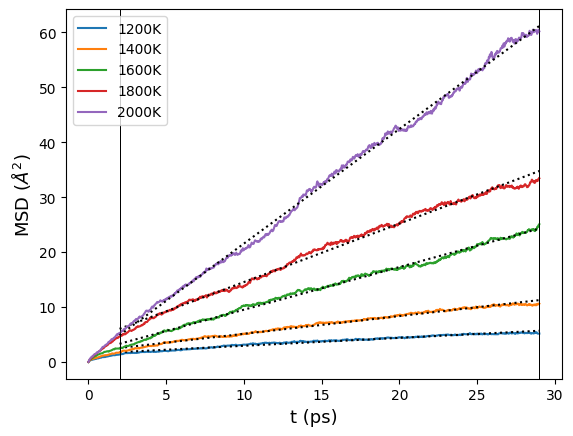

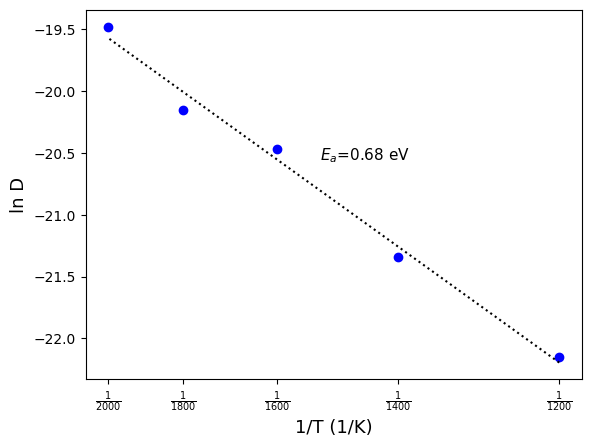

Ea = 0.6785762781142153 eV
D0 = 1.62404562699244e-07 m2/s


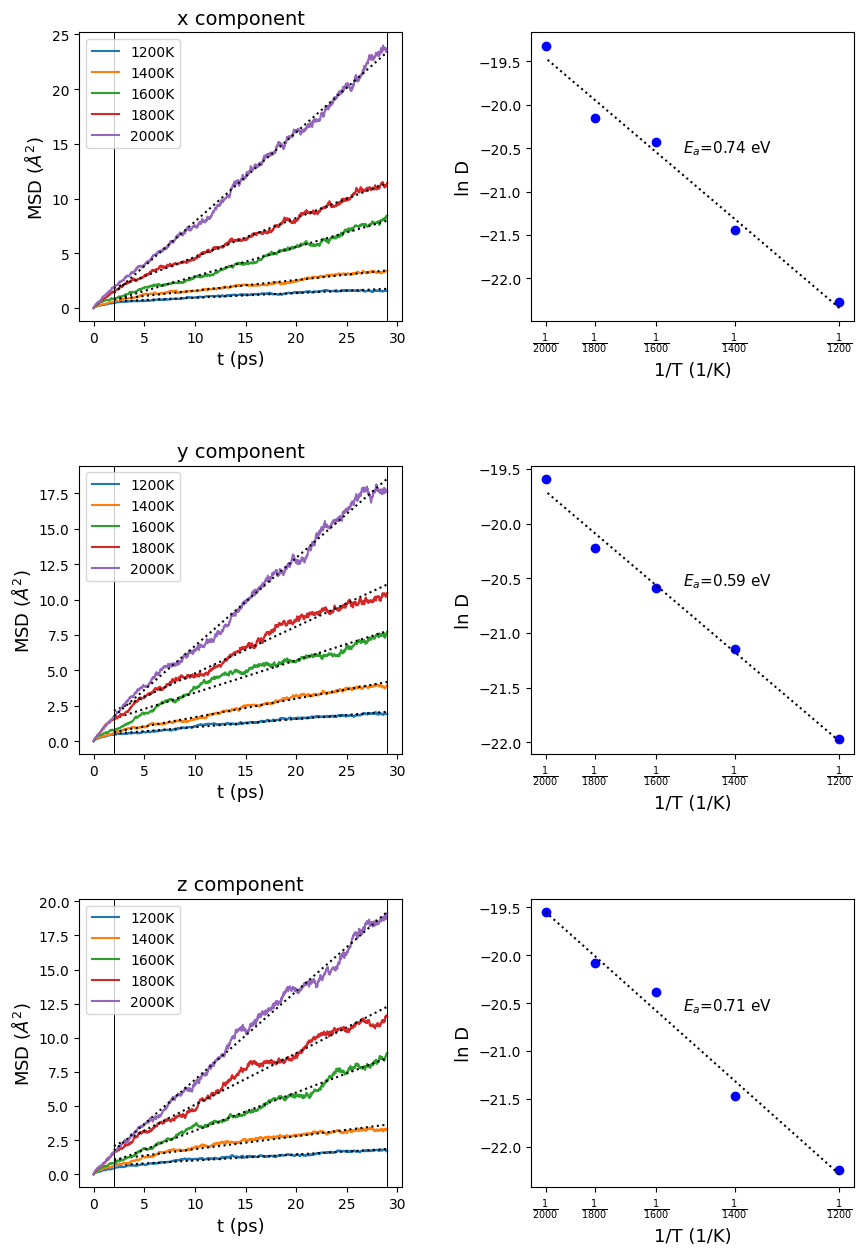

In [12]:
getDiffusivity(symbol='O',
               label=[format(i+1, '02') for i in range(10)],
               temp=np.arange(1200, 2000+1, 200),
               segment=1,
               skip=500,
               start=1000,
               end=14500,
               xdatcar='./xdatcar',
               xyz=True)

In [7]:
# symbol = 'O'
# labels = [format(i+1, '02') for i in range(10)]
# temps = np.arange(1200, 2000+1, 200)
# segments, skip, start, end = 1, 500, 1000, 14500
# # segments, skip, start, end = 2, 500, 1000, 7250

# ensembles = []
# for temp in tqdm(temps, desc="Total"):
#     ensemble = EnsembleEinstein(symbol=symbol,
#                                 prefix=f'xdatcar/xdatcar.{temp}K/',
#                                 labels=labels,
#                                 segments=segments,
#                                 skip=skip,
#                                 start=start,
#                                 end=end)
#     ensembles += [ensemble]

In [8]:
# def Arrehnius_fitting(temps, diffcoeffs, freq=1.0E13, verbose = True):
#     kb = 8.617332478E-5     # Boltzmann Constant in [eV/K]
#     temps, diffcoeffs = np.array(temps), np.array(diffcoeffs)
#     slop, intercept = np.polyfit(1/temps, np.log(diffcoeffs), deg=1)
#     tick = [f'1/{temp}' for temp in temps]
#     Ea_einstein = -slop*kb              # Diffusion barrier [eV]
#     D0 = np.exp(intercept)              # Pre-exponential [m^2/s]
#     a = np.sqrt(2 * D0 / freq) * 1.0E9  # hopping distance [nm]

#     plt.rcParams["figure.figsize"] = (8 ,4)
#     plt.plot(1/temps, np.log(diffcoeffs), 'bo')   # ln(D) = (-Ea/k_B)*(1/T)+ln(D0)
#     plt.plot(1/temps, slop*(1/temps)+intercept, 'k:')
#     plt.xlabel('1/T [1/K]', fontsize=13)
#     plt.xticks(1/temps, tick)
#     plt.ylabel('$ln(D*[s/m^2])$', fontsize=13)

#     mid = int(len(temps)/2)
#     plt.text(1/temps[mid]*1.05, slop*(1/temps[mid])+intercept, "$E_a$=%.2f eV"%(-slop*kb), fontsize=11)     # Text for Ea
#     # plt.text(1/temps[mid]*1.05, (slop*(1/temps[mid])+intercept)*1.0055, "a=%.2f nm (f=$10^{13}$ Hz)"%(a), fontsize=11)  # Text for a
#     # plt.savefig(f'Arrehnius_fitting.png', format='png')
#     plt.show()
    
#     if verbose:
#         print(f"Diffusion barrier (Ea): {Ea_einstein} eV")
#         print(f"Pre-exponeltial   (D0): {D0} [m2/s]")
#         print(f"hopping distance = {a} nm")
#         print("\nDiffusivity with respect to temperature:")
#         for i, d in enumerate(diffcoeffs):
#             T = tick[i].split('/')[-1]
#             print(f"\tT = {T} K,\tD = {d} m2/s")

In [9]:
# # Results
# figsize = (12,4)
# wspace = 0.4
# plt.figure(figsize=figsize)
# plt.subplots_adjust(wspace=wspace)

# plt.subplot(121)
# diffcoeffs = []
# for ensemble in ensembles:
#     ensemble.plotEnsembleMSD()
#     diffcoeffs += [ensemble.diffcoeff]
#     ensemble.saveMSD()

# plt.subplot(122)
# Arrehnius_fitting(temps=temps, diffcoeffs=diffcoeffs, freq=1.0E13, verbose=True)


In [10]:
# # x, y, z components
# figsize = (10,10)
# wspace = 0.4
# plt.figure(figsize=figsize)
# plt.subplots_adjust(wspace=wspace)

# plt.subplot(321)
# diffcoeffs_x = []
# for ensemble in ensembles:
#     ensemble.plotEnsembleMSD_x()
#     diffcoeffs_x += [ensemble.diffcoeff_x]

# plt.subplot(322)
# Arrehnius_fitting(temps=temps, diffcoeffs=diffcoeffs_x, verbose=False)

# plt.figure(figsize=figsize)
# plt.subplots_adjust(wspace=wspace)

# plt.subplot(323)
# diffcoeffs_y = []
# for ensemble in ensembles:
#     ensemble.plotEnsembleMSD_y()
#     diffcoeffs_y += [ensemble.diffcoeff_y]

# plt.subplot(324)
# Arrehnius_fitting(temps=temps, diffcoeffs=diffcoeffs_y, verbose=False)

# plt.figure(figsize=figsize)
# plt.subplots_adjust(wspace=wspace)

# plt.subplot(325)
# diffcoeffs_z = []
# for ensemble in ensembles:
#     ensemble.plotEnsembleMSD_z()
#     diffcoeffs_z += [ensemble.diffcoeff_z]

# plt.subplot(326)
# Arrehnius_fitting(temps=temps, diffcoeffs=diffcoeffs_z, verbose=False)